Цель довольно простая

In [43]:
import json

with open("short_term_dataset.json", "r") as f:
    df_json = json.load(f)

In [44]:
import pandas as pd

df = pd.DataFrame(df_json)

df[['prev_val_1', 'prev_val_2', 'prev_val_3', 'prev_val_4', 'prev_val_5', 'prev_val_6', 'prev_val_7']] = pd.DataFrame(df['prev_values'].tolist(), index=df.index)
df.drop(columns=['prev_values'], inplace=True)

In [45]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091973 entries, 0 to 2091972
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   price        float64
 1   gtin         object 
 2   item_group   object 
 3   day_of_week  object 
 4   date         object 
 5   y_true       float64
 6   prev_val_1   float64
 7   prev_val_2   float64
 8   prev_val_3   float64
 9   prev_val_4   float64
 10  prev_val_5   float64
 11  prev_val_6   float64
 12  prev_val_7   float64
dtypes: float64(9), object(4)
memory usage: 207.5+ MB


In [46]:
df['price'] = df['price']/100
df.drop(columns=['item_group'], inplace=True)


df[['month', 'day']] = df['date'].str.split('-', expand=True)

# Convert month and day columns to integers
df['month'] = df['month'].astype(int)

df['day'] = df['day'].astype(int)

df.drop(columns=['date'], inplace=True)

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(), ['day_of_week'])],
    remainder='passthrough',
)

ridge_reg = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regression_ridge', Ridge())])

# df['Monday'] = (df['day_of_week']=='Понедельник').astype(int)
# df['Tuesday'] = (df['day_of_week']=='Вторник').astype(int)
# df['Wednesday'] = (df['day_of_week'] == 'Среда').astype(int)
# df['Thursday'] = (df['day_of_week']=='Четверг').astype(int)
# df['Friday'] = (df['day_of_week'] == 'Пятница').astype(int)
# df['Saturday'] = (df['day_of_week'] == 'Суббота').astype(int)
# df['Sunday'] = (df['day_of_week'] == 'Воскресенье').astype(int)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['gtin', 'y_true', 'day', 'month']), df['y_true'], test_size=0.2, random_state=44)



In [52]:
print(X_train.shape)
print(type(y_train))

(1673578, 9)
<class 'pandas.core.series.Series'>


In [78]:
ridge_reg.fit(X_train, y_train)
print("Score:", ridge_reg.score(X_test, y_test))
print("MAE:", mean_absolute_error(ridge_reg.predict(X_test), y_test))


Score: 0.703674356952751
MAE: 1.0124982260719189


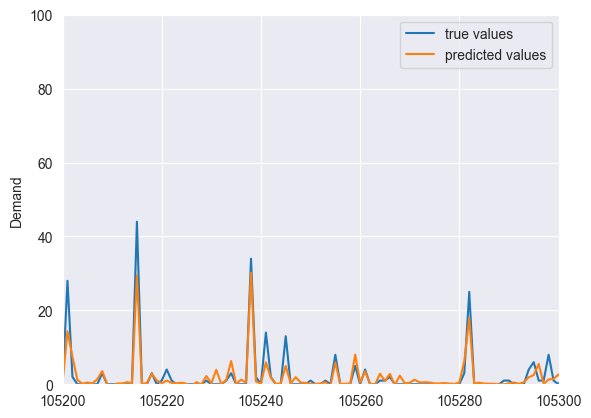

In [81]:

from matplotlib import pyplot as plt


def show_adekvantost(true, predict):
    plt.plot(true.reset_index(drop=True), label='true values')
    plt.plot(predict, label='predicted values')
    plt.ylabel("Demand")
    plt.legend()
    plt.xlim(105200, 105300)
    plt.ylim(0, 100)
    plt.show()

predicts = ridge_reg.predict(X_test)
show_adekvantost(y_test, predicts)


Можно видеть, что линрег отлично справился со своей задачей и достаточно точно предсказывает спрос. Прям будто очень хорошо. Я прошёлся графиком по нескольким сотням строчек и видно, что тренды довольно точно b адекватно предсказываются.
Теперь думаю попробовать использовать catBoost и RandomForest, посмотрим, насколько лучше метрики себя будут вести и т.д.


In [61]:
from sklearn.ensemble import RandomForestRegressor

random_forest = Pipeline(steps=[('preprocessor', preprocessor), ('rfr', RandomForestRegressor(n_jobs=-1, n_estimators=20))])

random_forest.fit(X_train, y_train)
print("Score:", random_forest.score(X_test, y_test))
print("MAE:", mean_absolute_error(random_forest.predict(X_test), y_test))

Score: 0.7888250329596193
MAE: 0.8480554593529213


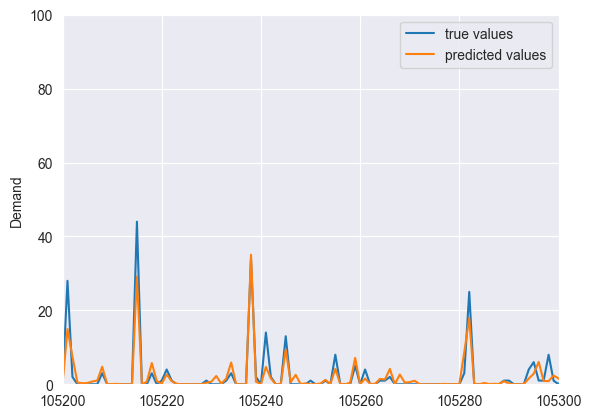

In [82]:
rf_predicts = random_forest.predict(X_test)
show_adekvantost(y_test, rf_predicts)


Random forest показал себя лучше линрега (удивительно)

In [79]:
import catboost as cb

cb_reg = Pipeline(steps=[('preprocessor', preprocessor),
                            ('catboost', cb.CatBoostRegressor())])

cb_reg.fit(X_train, y_train)
print("Score:", cb_reg.score(X_test, y_test))
print("MAE:", mean_absolute_error(cb_reg.predict(X_test), y_test))

Learning rate set to 0.132287
0:	learn: 6.0728896	total: 246ms	remaining: 4m 6s
1:	learn: 5.5834916	total: 334ms	remaining: 2m 46s
2:	learn: 5.1717804	total: 410ms	remaining: 2m 16s
3:	learn: 4.8267746	total: 489ms	remaining: 2m 1s
4:	learn: 4.5337840	total: 611ms	remaining: 2m 1s
5:	learn: 4.2866578	total: 716ms	remaining: 1m 58s
6:	learn: 4.0809406	total: 816ms	remaining: 1m 55s
7:	learn: 3.9045956	total: 923ms	remaining: 1m 54s
8:	learn: 3.7629599	total: 1.06s	remaining: 1m 56s
9:	learn: 3.6412997	total: 1.19s	remaining: 1m 58s
10:	learn: 3.5350712	total: 1.32s	remaining: 1m 58s
11:	learn: 3.4490075	total: 1.47s	remaining: 2m 1s
12:	learn: 3.3780020	total: 1.58s	remaining: 1m 59s
13:	learn: 3.3195841	total: 1.7s	remaining: 1m 59s
14:	learn: 3.2672262	total: 1.8s	remaining: 1m 58s
15:	learn: 3.2223895	total: 1.92s	remaining: 1m 58s
16:	learn: 3.1852557	total: 2.05s	remaining: 1m 58s
17:	learn: 3.1536192	total: 2.18s	remaining: 1m 59s
18:	learn: 3.1241756	total: 2.3s	remaining: 1m 58s

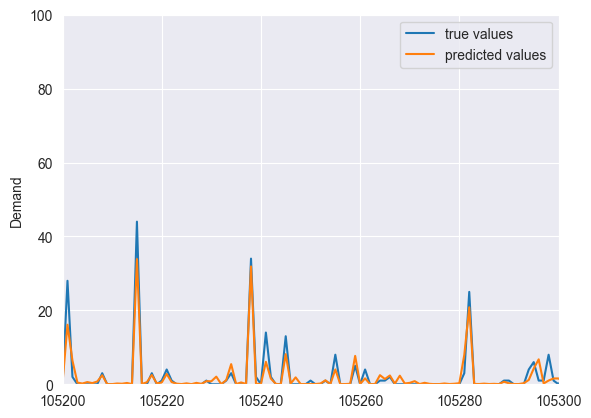

In [83]:
cb_predicts = cb_reg.predict(X_test)
show_adekvantost(y_test, cb_predicts)

CatBoost regressor пока что показывает самые лучшие данные по метрикам, по графикам методом зоркого взгляда разницы уже не ощущается. Надо подумать что ещё можно было бы заюзать, хотя мне кажется, что этого достаточно, и стоит думать, а как мне теперь улучшить датасет. Сделать его плотнее и убрать те продукты у которых спрос как у говна? Вероятно, это повысит качество предсказываний. Но в реале то будут и говно загружать в датасет не?